In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'sans-serif' 
plt.rcParams['font.sans-serif'] = 'DejaVu Serif' 

In [2]:
df = pd.read_csv("results_aggregated.csv", index_col=0)
df.head()

,model_name,setting,nmax,offset,n_icl_example,cf_acc,orig_acc
0,Qwen/Qwen2.5-7B,normal,9,-2,2,0.04,0.61
1,Qwen/Qwen2.5-7B,normal,9,-2,4,0.08,0.55
2,Qwen/Qwen2.5-7B,normal,9,-2,8,0.11,0.52
3,Qwen/Qwen2.5-7B,normal,9,-2,16,0.18,0.47
4,Qwen/Qwen2.5-7B,normal,9,-2,32,0.28,0.37


In [3]:
filter = lambda row: row["nmax"] == 999 and row["offset"] == 1
df_filtered = df[df.apply(filter, axis=1)]

In [4]:
model_names = ["meta-llama/Llama-2-7b-hf", "google/gemma-2-9b" , "Qwen/Qwen2.5-7B", "mistralai/Mistral-7B-v0.1", "meta-llama/Meta-Llama-3-8B", "microsoft/phi-4"]

model_color = {
    'meta-llama/Llama-2-7b-hf': '#E85E51',
    'google/gemma-2-9b': '#F59562',
    'Qwen/Qwen2.5-7B': '#e9c46a',
    'mistralai/Mistral-7B-v0.1': '#30B392',
    'meta-llama/Meta-Llama-3-8B': '#4FC6E0',
    'microsoft/phi-4': '#A653A6'
}

display_name = {
    'meta-llama/Llama-2-7b-hf': 'Llama-2 (7B)',
    'google/gemma-2-9b': 'Gemma-2 (9B)',
    'Qwen/Qwen2.5-7B': 'Qwen-2.5 (7B)',
    'mistralai/Mistral-7B-v0.1': 'Mistral-v0.1 (7B)',
    'meta-llama/Meta-Llama-3-8B': 'Llama-3 (8B)',
    'microsoft/phi-4': 'Phi-4 (14B)'
}

colors = ["#E85E51", "#F59562", "#e9c46a", "#30B392", "#4FC6E0", "#A653A6"]


In [5]:
all_setting_dict = {}
for setting in ["normal", "setting1", "setting2"]:
    plot_dict = {}
    for model_name in model_names:
        model_df = df_filtered[(df_filtered["model_name"] == model_name) & (df_filtered["setting"] == setting)]
        plot_dict[model_name] = {
            "n_icl_example": model_df["n_icl_example"].tolist(),  
            "cf_acc": model_df["cf_acc"].tolist(), 
            "orig_acc": model_df["orig_acc"].tolist()
        }
    all_setting_dict[setting] = plot_dict

### Main Figure

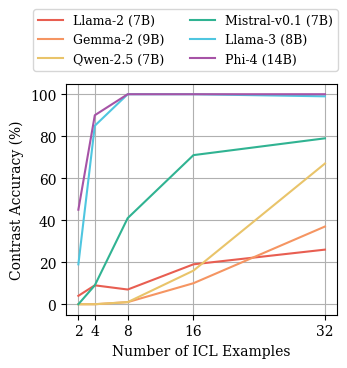

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(3.5, 3))

setting = "setting1"
result = all_setting_dict[setting]
for model in model_names:
    metrics = result[model]
    n_icl_example = metrics['n_icl_example']
    cf_acc = metrics['cf_acc']
    orig_acc = metrics['orig_acc']

    ax.plot(n_icl_example, cf_acc, label=display_name[model], color=model_color[model], linestyle='-')
    
ax.set_xlabel('Number of ICL Examples')
ax.set_xticks(n_icl_example)
ax.set_ylabel('Contrast Accuracy (%)')
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax.set_yticklabels(["0", "20", "40", "60", "80", "100"])
ax.grid(True)

plt.legend(bbox_to_anchor=(0.44, 1.35), loc='upper center', ncol=2, fontsize=9)

# plt.savefig("off_by_one_performance.pdf", dpi=300, bbox_inches='tight', pad_inches=0.0)
plt.show()


### Other Figures

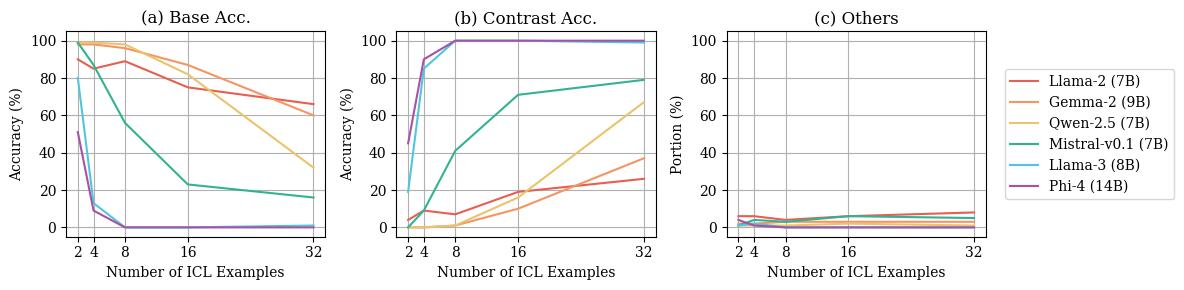

In [7]:
setting = "setting1"

fig, axes = plt.subplots(1, 3, figsize=(12, 3))

titles = ["(a) Base Acc.", "(b) Contrast Acc.", "(c) Others"]
for i in range(3):
    ax = axes[i]
    result = all_setting_dict[setting]
    for model in model_names:
        metrics = result[model]
        n_icl_example = metrics['n_icl_example']
        cf_acc = metrics['cf_acc']
        orig_acc = metrics['orig_acc']
        color = model_color[model]
        
        if i == 0:
            ax.plot(n_icl_example, orig_acc, label=f'{model.split("/")[-1]} (orig)', color=color, linestyle='-')
        elif i == 1:
            ax.plot(n_icl_example, cf_acc, label=f'{model.split("/")[-1]} (cf)', color=color, linestyle='-')
        elif i == 2:
            ax.plot(n_icl_example, 1.0 - np.array(cf_acc) - np.array(orig_acc), label=display_name[model], color=color, linestyle='-')
            
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_yticklabels(["0", "20", "40", "60", "80", "100"])

    ax.set_xlabel('Number of ICL Examples')
    ax.set_xticks(n_icl_example)
    ax.set_ylabel('Portion (%)' if i == 2 else 'Accuracy (%)')
    ax.set_title(titles[i])
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True)

plt.legend(bbox_to_anchor=(1.4, 0.5), loc='center')
plt.tight_layout()
# plt.savefig("off_by_one_base_acc.pdf", dpi=300, bbox_inches='tight', pad_inches=0.0)
plt.show()

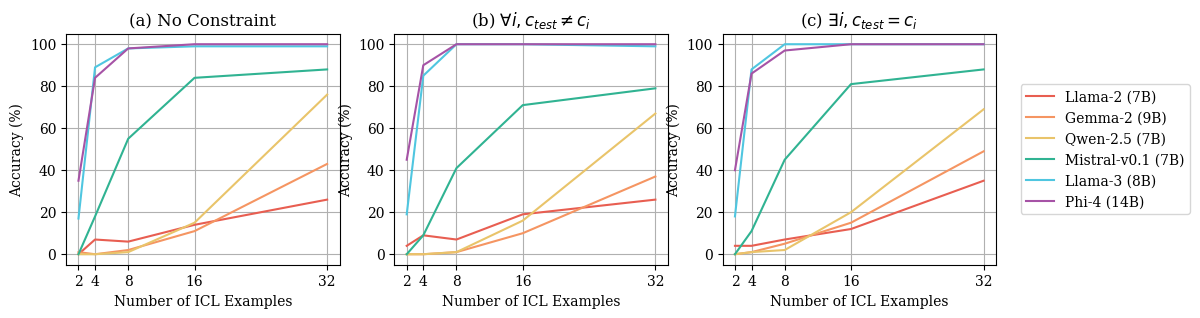

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

titles = ["(a) No Constraint", r"(b) $\forall i, c_{test} \neq c_i$", r"(c) $\exists i, c_{test} = c_i$"]
for i, setting in enumerate(["normal", "setting1", "setting2"]):
    ax = axes[i]
    result = all_setting_dict[setting]
    for model in model_names:
        metrics = result[model]
        n_icl_example = metrics['n_icl_example']
        cf_acc = metrics['cf_acc']
        orig_acc = metrics['orig_acc']
        color = model_color[model]
        
        ax.plot(n_icl_example, cf_acc, label=display_name[model], color=color, linestyle='-')
        
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_yticklabels(["0", "20", "40", "60", "80", "100"])
    ax.set_xlabel('Number of ICL Examples')
    ax.set_xticks(n_icl_example)
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(titles[i])
    ax.grid(True)

plt.legend(bbox_to_anchor=(1.4, 0.5), loc='center')
# plt.savefig("off_by_one_ci_settings.pdf", dpi=300, bbox_inches='tight', pad_inches=0.0)
plt.show()

In [9]:
def parse_results(df, nmax):
    filter = lambda row: row["nmax"] == nmax and row["offset"] == 1
    df_filtered = df[df.apply(filter, axis=1)]
    setting = "setting1"
    plot_dict = {}
    for model_name in model_names:
        model_df = df_filtered[(df_filtered["model_name"] == model_name) & (df_filtered["setting"] == setting)]
        plot_dict[model_name] = {
            "n_icl_example": model_df["n_icl_example"].tolist(),  
            "cf_acc": model_df["cf_acc"].tolist(), 
            "orig_acc": model_df["orig_acc"].tolist()
        }
    return plot_dict

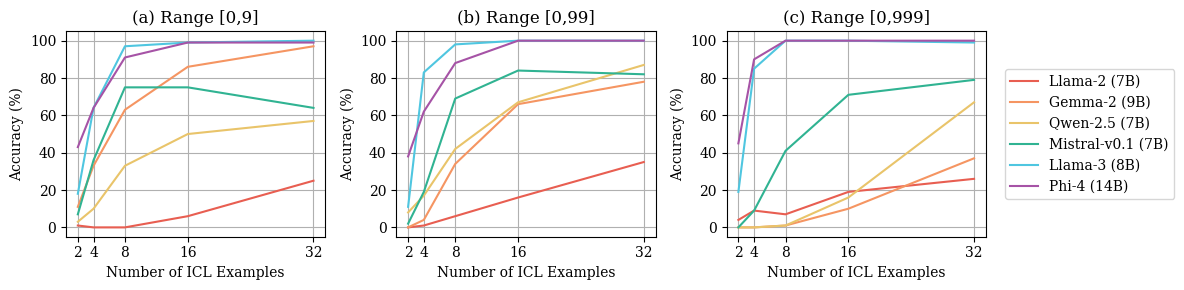

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

titles = ["(a) Range [0,9]", "(b) Range [0,99]", "(c) Range [0,999]"]
for i, nmax in enumerate([9, 99, 999]):
    ax = axes[i]
    
    result = parse_results(df, nmax)
    for model in model_names:
        metrics = result[model]
        n_icl_example = metrics['n_icl_example']
        cf_acc = metrics['cf_acc']
        orig_acc = metrics['orig_acc']
        color = model_color[model]
    
        ax.plot(n_icl_example, cf_acc, label=display_name[model], color=color, linestyle='-')

    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    ax.set_yticklabels(["0", "20", "40", "60", "80", "100"])

    ax.set_xlabel('Number of ICL Examples')
    ax.set_xticks(n_icl_example)
    ax.set_ylabel('Accuracy (%)')
    ax.set_title(titles[i])
    ax.set_ylim(-0.05, 1.05)
    ax.grid(True)

plt.legend(bbox_to_anchor=(1.4, 0.5), loc='center')
# plt.savefig("off_by_one_ranges.pdf", dpi=300, bbox_inches='tight', pad_inches=0.0)
plt.tight_layout()
plt.show()

### Off-by-k Figures

In [11]:
from matplotlib.lines import Line2D


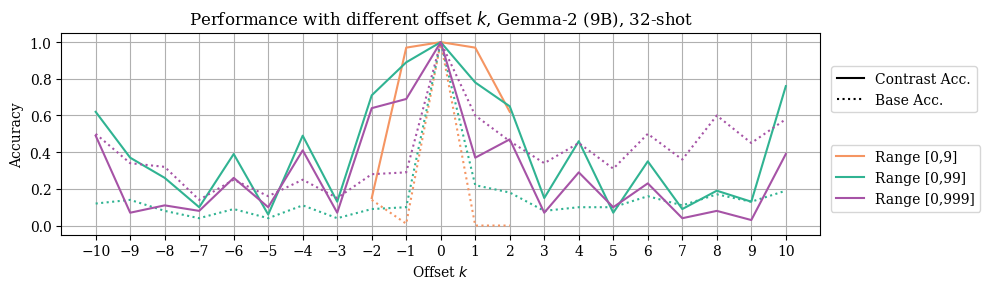

In [12]:
model_name = "google/gemma-2-9b"
# model_name = "meta-llama/Meta-Llama-3-8B"
filter = lambda row: row["model_name"] == model_name and row["setting"] == "setting1" and row["n_icl_example"] == 32
df_filtered = df[df.apply(filter, axis=1)]

plot_dict = {}
for nmax in [9, 99, 999]:
    sub_df = df_filtered[df_filtered["nmax"] == nmax]
    plot_dict[nmax] = {
            "offset": sub_df["offset"].tolist(),  
            "cf_acc": sub_df["cf_acc"].tolist(), 
            "orig_acc": sub_df["orig_acc"].tolist()
        }

fig, ax = plt.subplots(1, 1, figsize=(10, 3))
# fig.subplots_adjust(right=0.75)
colors_ = [colors[1], colors[3], colors[5]]

i = 0
for nmax, results in plot_dict.items():
    offset = results['offset']
    cf_acc = results['cf_acc']
    orig_acc = results['orig_acc']
    
    ax.plot(offset, cf_acc, label=f'{nmax} (cf)', color=colors_[i], linestyle='-')
    ax.plot(offset, orig_acc, label=f'{nmax} (orig)', color=colors_[i], linestyle=':')
    
    i+= 1

ax.set_xlabel(r'Offset $k$')
ax.set_xticks(offset)
ax.set_ylabel('Accuracy')
ax.set_title(r"Performance with different offset $k$" + ", {}, 32-shot".format(display_name[model_name]))
ax.grid(True)

# Legend 2: nmax values
color_legend = [
    Line2D([0], [0], color=colors_[0], linestyle='-', label='Range [0,9]'),
    Line2D([0], [0], color=colors_[1], linestyle='-', label='Range [0,99]'),
    Line2D([0], [0], color=colors_[2], linestyle='-', label='Range [0,999]'),
]
legend2 = ax.legend(handles=color_legend, loc='right', bbox_to_anchor=(1.22, 0.28), title="")
ax.add_artist(legend2)  # Add the first legend manually


# Legend 1: Line styles
style_legend = [
    Line2D([0], [0], color='black', linestyle='-', label='Contrast Acc.'),
    Line2D([0], [0], color='black', linestyle=':', label='Base Acc.')
]
legend1 = ax.legend(handles=style_legend, loc='right', bbox_to_anchor=(1.215, 0.72), title="")


# plt.savefig("off_by_k_llama_3.pdf", dpi=300, bbox_inches='tight', pad_inches=0.05)
plt.tight_layout()
plt.show()